In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import pandas as pd
from keras.regularizers import l2
import random
import statsmodels.api as sm
import numpy as np
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
from sklearn.preprocessing import label_binarize
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from functools import reduce
import pickle
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import all_estimators
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
seed = 42

In [3]:
datos = pd.read_csv('datos.csv')

In [4]:
datos2 = pd.read_csv('datos2.csv')

In [5]:
X, y = datos.drop("Parar", axis="columns"), datos["Parar"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
data_train = pd.concat([X_train, y_train], axis = 1)
data_test = pd.concat([X_test,y_test], axis=1)

In [7]:
X_train = data_train[data_train["Parar"] == "si"]
X_train = X_train.drop(["Parar"], axis=1).reset_index(drop=True)
X_test = data_test[data_test["Parar"] == "si"]
X_test = X_test.drop(["Parar"], axis=1).reset_index(drop=True)

columnas = datos2.columns.tolist()
columnas2 = columnas.copy()
columnas2 = columnas2.remove('CompuestoBueno')

X_train = X_train.merge(datos2[columnas], on=columnas2, how='inner')
X_test = X_test.merge(datos2[columnas], on=columnas2, how='inner')

X_train = X_train[X_train['CompuestoBueno'] != 'UNKNOWN']
X_test = X_test[X_test['CompuestoBueno'] != 'UNKNOWN']

y_train = X_train["CompuestoBueno"]
data_train = pd.concat([X_train, y_train], axis=1)
X_train = X_train.drop("CompuestoBueno", axis=1)

y_test = X_test["CompuestoBueno"]
data_test = pd.concat([X_test, y_test], axis=1)
X_test = X_test.drop("CompuestoBueno", axis=1)

In [8]:
v_continuas = X_train.columns[(X.dtypes == 'float64') | (X_train.dtypes == 'int')]
v_discretas =  [col for col in X_train.columns if col not in v_continuas]
print("Variables continuas: ",len(v_continuas))
print("Variables discretas: ",len(v_discretas))

Variables continuas:  6
Variables discretas:  22


In [9]:
type_filter = ["transformer"]
transformers = all_estimators(type_filter=type_filter)

transformers = dict(transformers)

standardscaler = transformers["StandardScaler"]()

columnTransformerAvanzado = make_column_transformer(
    (standardscaler, v_continuas),
    (OneHotEncoder(handle_unknown='ignore'), v_discretas)
)

# RF

In [31]:
param_grid = {
    'randomforestclassifier__n_estimators': [100, 300, 500, 600],
    'randomforestclassifier__max_depth': [None, 5, 15, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [2, 5],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__class_weight': ['balanced']
}
    
rf_model = RandomForestClassifier(random_state=seed)
pipeline = make_pipeline(columnTransformerAvanzado, rf_model)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='micro'),
    cv=5
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_rf_model = grid_search.best_estimator_

print(f'Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 300}


In [32]:
joblib.dump(grid_search, 'best_random_forest_model2.pkl')
rf_model2 = joblib.load('best_random_forest_model2.pkl')

In [33]:
y_pred = rf_model2.predict(X_test)

test_classification_rep = classification_report(y_test, y_pred)

print("Test Classification Report:")
print(test_classification_rep)


Test Classification Report:
              precision    recall  f1-score   support

        HARD       0.75      0.87      0.80       297
INTERMEDIATE       0.83      0.91      0.87        54
      MEDIUM       0.78      0.72      0.75       269
        SOFT       0.62      0.45      0.52       118
         WET       0.69      0.82      0.75        11

    accuracy                           0.75       749
   macro avg       0.73      0.75      0.74       749
weighted avg       0.74      0.75      0.74       749



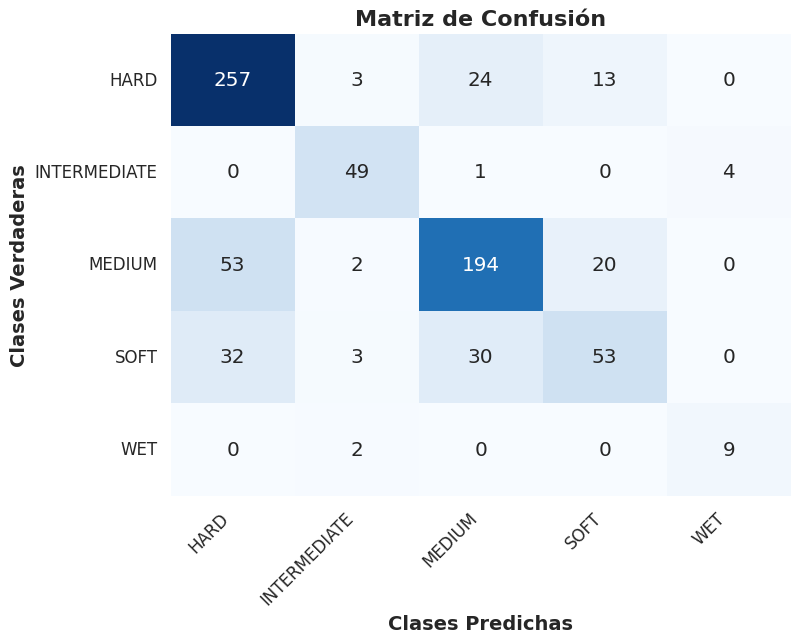

In [34]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

class_names= ['HARD', 'INTERMEDIATE', 'MEDIUM', 'SOFT', 'WET']

# Crear figura y ejes
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajustar el tamaño de la fuente para una mejor visualización

# Crear el mapa de calor
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Añadir etiquetas y títulos
plt.xlabel('Clases Predichas', fontsize=14, fontweight='bold')
plt.ylabel('Clases Verdaderas', fontsize=14, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')

# Añadir nombres de las clases a los ejes centrados con el cuadrado
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=45, ha='right', fontsize=12)
plt.yticks(tick_marks + 0.5, class_names, rotation=0, fontsize=12)

# Mostrar el gráfico
plt.show()

# SVM

In [36]:
svm_classifier = SVC(class_weight='balanced')

pipeline = Pipeline([
    ('column_transformer', columnTransformerAvanzado),
    ('svm_classifier', svm_classifier)
])

param_grid = {
    'svm_classifier__C': [0.01, 0.1, 1, 10, 15],
    'svm_classifier__gamma': [0.01, 0.1, 1, 5],
    'svm_classifier__kernel': ['rbf', 'poly'],
    'svm_classifier__decision_function_shape': ['ovo', 'ovr']
}

# Define la función de puntuación F1 personalizada
scorer = make_scorer(f1_score, average='micro')

# Realiza la búsqueda de parámetros mediante validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=5
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f'Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'svm_classifier__C': 0.1, 'svm_classifier__decision_function_shape': 'ovo', 'svm_classifier__degree': 4, 'svm_classifier__gamma': 0.1, 'svm_classifier__kernel': 'poly'}


In [37]:
joblib.dump(grid_search, 'best_svm_model2.pkl')
svm_model2 = joblib.load('best_svm_model2.pkl')

In [38]:
from sklearn.preprocessing import label_binarize
y_pred = svm_model2.predict(X_test)

test_classification_rep = classification_report(y_test, y_pred)

print("Test Classification Report:")
print(test_classification_rep)


Test Classification Report:
              precision    recall  f1-score   support

        HARD       0.74      0.81      0.77       297
INTERMEDIATE       0.83      0.80      0.81        54
      MEDIUM       0.71      0.71      0.71       269
        SOFT       0.61      0.48      0.54       118
         WET       0.69      0.82      0.75        11

    accuracy                           0.72       749
   macro avg       0.72      0.72      0.72       749
weighted avg       0.72      0.72      0.72       749



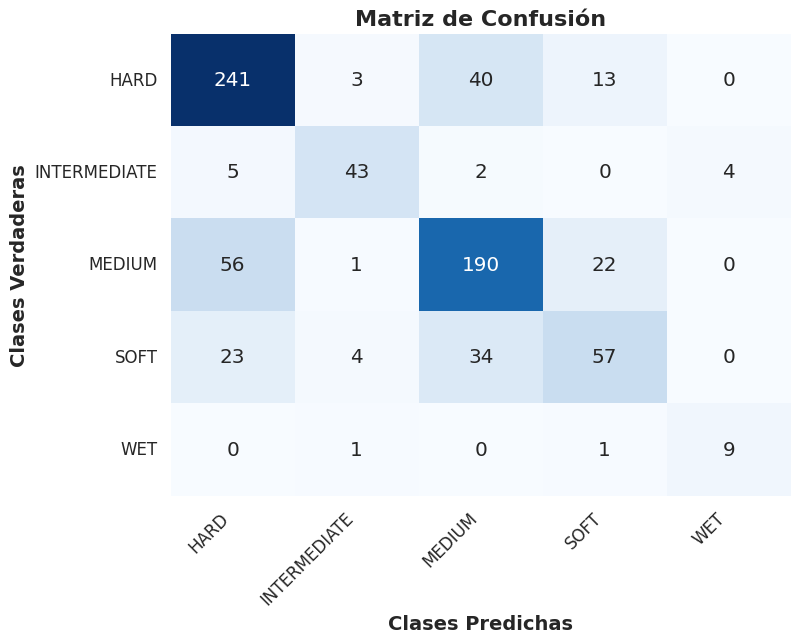

In [39]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

class_names= ['HARD', 'INTERMEDIATE', 'MEDIUM', 'SOFT', 'WET']

# Crear figura y ejes
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajustar el tamaño de la fuente para una mejor visualización

# Crear el mapa de calor
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Añadir etiquetas y títulos
plt.xlabel('Clases Predichas', fontsize=14, fontweight='bold')
plt.ylabel('Clases Verdaderas', fontsize=14, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')

# Añadir nombres de las clases a los ejes centrados con el cuadrado
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=45, ha='right', fontsize=12)
plt.yticks(tick_marks + 0.5, class_names, rotation=0, fontsize=12)

# Mostrar el gráfico
plt.show()

# RN

In [10]:
X_train_processed = columnTransformerAvanzado.fit_transform(X_train)
X_train_processed_tensor = tf.convert_to_tensor(X_train_processed.todense(), dtype=tf.float32)

X_test_processed = columnTransformerAvanzado.transform(X_test)
X_test_processed_tensor = tf.convert_to_tensor(X_test_processed.todense(), dtype=tf.float32)

In [11]:
label_encoder = LabelEncoder()

# Convertir las etiquetas de clases a números enteros
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [12]:
class_weight_dict = {0: 1, 1: 1.5, 2: 1.5, 3: 1.5, 4: 5}

In [14]:
X_train_processed_tensor = np.array(X_train_processed_tensor)
y_train_encoded = np.array(y_train_encoded)

In [16]:
def create_model(optimizer='adam', activation='relu', init_mode='glorot_uniform', neurons=256, l2_value=0.01):
    inputs = Input(shape=(X_train_processed_tensor.shape[1],))
    x = Dense(neurons, activation=activation, kernel_regularizer=l2(l2_value), kernel_initializer=init_mode)(inputs)
    x = Dropout(0.5)(x)
    x = Dense(int(neurons/2), activation=activation, kernel_regularizer=l2(l2_value), kernel_initializer=init_mode)(x)
    x = Dense(int(neurons/4), activation=activation, kernel_regularizer=l2(l2_value), kernel_initializer=init_mode)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = KerasClassifier(model=create_model, verbose=0, optimizer='adam', activation='relu', init_mode='glorot_uniform', neurons=256, l2_value=0.01)


param_grid = {
    'batch_size': [16,32,64],
    'epochs': [50, 75, 100],
    'activation': ['relu','tanh'],
    'neurons': [32, 64, 128],
    'l2_value': [0.01, 0.001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

grid_result = grid.fit(X_train_processed_tensor, y_train_encoded)

print(f"Mejores parámetros: {grid_result.best_params_}")


Mejores parámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 75, 'l2_value': 0.01, 'neurons': 64}


Epoch 1/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.3431 - loss: 3.3590 - val_accuracy: 0.4750 - val_loss: 2.1202
Epoch 2/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4373 - loss: 2.4498 - val_accuracy: 0.5217 - val_loss: 1.6952
Epoch 3/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4936 - loss: 2.0982 - val_accuracy: 0.6317 - val_loss: 1.4536
Epoch 4/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6146 - loss: 1.7877 - val_accuracy: 0.6417 - val_loss: 1.3336
Epoch 5/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6423 - loss: 1.6108 - val_accuracy: 0.6483 - val_loss: 1.2591
Epoch 6/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6619 - loss: 1.4951 - val_accuracy: 0.6333 - val_loss: 1.2338
Epoch 7/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6504 - loss: 1.4593 - val_accuracy: 0.6717 - val_loss: 1.1787
Epoch 8/70
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6784 - loss: 1.4248 - val_accuracy: 0.6483 - val_loss

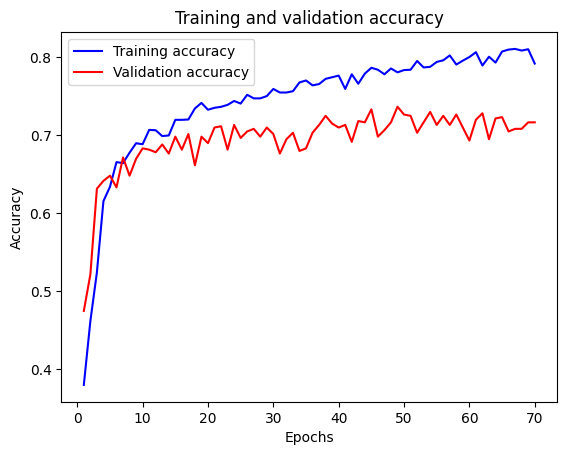

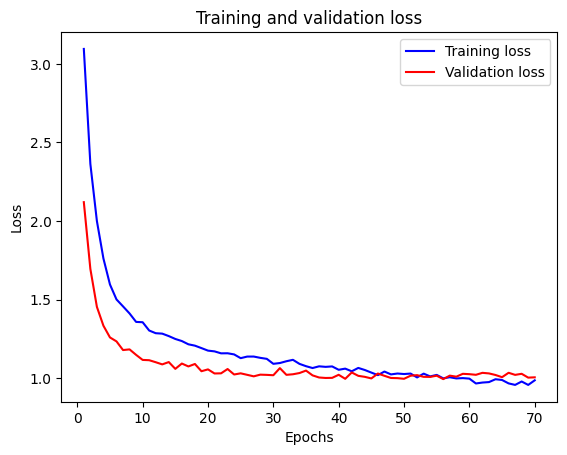

In [18]:
inputs = Input(shape=(X_train_processed_tensor.shape[1],))
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inputs)
x = Dropout(0.5)(x) 
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model_nn2.keras',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train_processed_tensor, y_train_encoded,
                    epochs=70,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[model_checkpoint_callback])  

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
best_model_nn2 = load_model('best_model_nn2.keras')

y_test_pred = best_model_nn2.predict(X_test_processed_tensor)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)

y_test_pred_labels = label_encoder.inverse_transform(y_test_pred_classes)

test_classification_rep = classification_report(y_test, y_test_pred_labels)

print("Test Classification Report:")
print(test_classification_rep)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Classification Report:
              precision    recall  f1-score   support

        HARD       0.72      0.87      0.78       297
INTERMEDIATE       0.82      0.69      0.75        54
      MEDIUM       0.72      0.72      0.72       269
        SOFT       0.68      0.36      0.48       118
         WET       0.67      0.73      0.70        11

    accuracy                           0.72       749
   macro avg       0.72      0.67      0.69       749
weighted avg       0.72      0.72      0.71       749



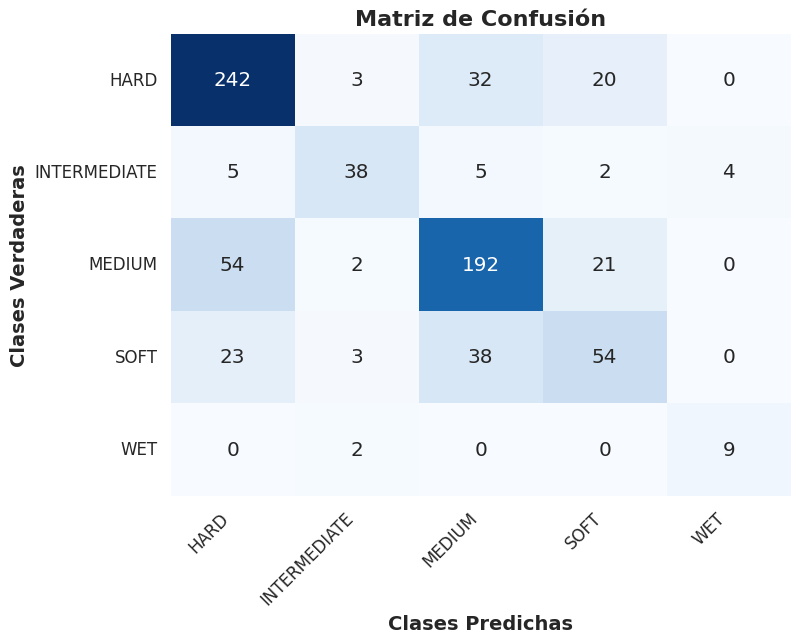

In [48]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred_labels)

class_names= ['HARD', 'INTERMEDIATE', 'MEDIUM', 'SOFT', 'WET']

# Crear figura y ejes
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajustar el tamaño de la fuente para una mejor visualización

# Crear el mapa de calor
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Añadir etiquetas y títulos
plt.xlabel('Clases Predichas', fontsize=14, fontweight='bold')
plt.ylabel('Clases Verdaderas', fontsize=14, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')

# Añadir nombres de las clases a los ejes centrados con el cuadrado
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=45, ha='right', fontsize=12)
plt.yticks(tick_marks + 0.5, class_names, rotation=0, fontsize=12)

# Mostrar el gráfico
plt.show()

# Ensemble

In [22]:
rf_model2 = joblib.load('modelos/best_random_forest_model2.pkl')
svm_model2 = joblib.load('modelos/best_svm_model2.pkl')
best_model_nn2 = load_model('modelos/best_model_nn2.keras')

In [23]:
from collections import Counter

rf_predictions = rf_model2.predict(X_test) 

svm_predictions = svm_model2.predict(X_test) 

y_test_pred = best_model_nn2.predict(X_test_processed_tensor)
nn_predictions = np.argmax(y_test_pred, axis=1)
nn_predictions = label_encoder.inverse_transform(nn_predictions)

# Hacer el voto por mayoría para cada instancia
final_predictions = []

for rf_pred, svm_pred, nn_pred in zip(rf_predictions, svm_predictions, nn_predictions):
    all_preds = [rf_pred, svm_pred, nn_pred]
    class_counts = Counter(all_preds)
    majority_class = class_counts.most_common(1)[0][0]
    
    # En caso de un triple empate
    if len(class_counts) == 3:
        dry_tyres = ['HARD', 'MEDIUM', 'SOFT']
        wet_tyres = ['INTERMEDIATE', 'WET']
        dry_counts = sum(class_counts.get(tyre, 0) for tyre in dry_tyres)
        wet_counts = sum(class_counts.get(tyre, 0) for tyre in wet_tyres)
        
        if dry_counts == 1 and wet_counts == 2:
            majority_class = 'INTERMEDIATE'
        elif dry_counts == 2 and wet_counts == 1:
            majority_class = rf_pred
        elif dry_counts == 3:
            majority_class = rf_pred
    
    final_predictions.append(majority_class)

test_classification_rep = classification_report(y_test, final_predictions)

print("Test Classification Report:")
print(test_classification_rep)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Classification Report:
              precision    recall  f1-score   support

        HARD       0.75      0.87      0.80       297
INTERMEDIATE       0.83      0.83      0.83        54
      MEDIUM       0.77      0.72      0.75       269
        SOFT       0.64      0.46      0.53       118
         WET       0.69      0.82      0.75        11

    accuracy                           0.75       749
   macro avg       0.74      0.74      0.73       749
weighted avg       0.74      0.75      0.74       749

